In [23]:
import os
_FINAL_DFS_DIR = os.path.join('..', '..', 'final_dfs')

import sys
sys.path.append('..')
import plotconfig

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import FuncFormatter
from scipy import stats
import pandas as pd
import numpy as np

In [25]:
dbf = os.path.join(_FINAL_DFS_DIR, 'results.parquet')
df = pd.read_parquet(dbf, engine='pyarrow')

mask = ((df['method_name'] != "BestSVR") &
        (df['method_name'] != "BestMLP") &
        (df['eeg_name'] == "EEG_Raw") & 
        (df['test_name'] == "diagonal"))

df = df[mask]
df['method_name'].unique()

array(['LinearRegression', 'Shuffle_LinearRegression',
       'DummyScoring_Mean', 'SVR', 'MLP'], dtype=object)

In [26]:
columns_to_clean = ['signal_to_uncertainty_ratio']

for col in columns_to_clean:
    if col in df.columns:
        # Replace inf values with 0
        df[col] = df[col].replace([np.inf, -np.inf], 0)
        # Also replace any NaN values that might exist
        df[col] = df[col].fillna(0)
        print(f"Cleaned {col}")
    else:
        print(f"Skipped {col} (column not found)")

Cleaned signal_to_uncertainty_ratio


['LinearRegression', 'Shuffle_LinearRegression', 'DummyScoring_Mean', 'SVR', 'MLP']
['Linear Regression', 'Shuffle Linear Regression', 'Mean Dummy Regressor', 'SVR', 'MLP']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


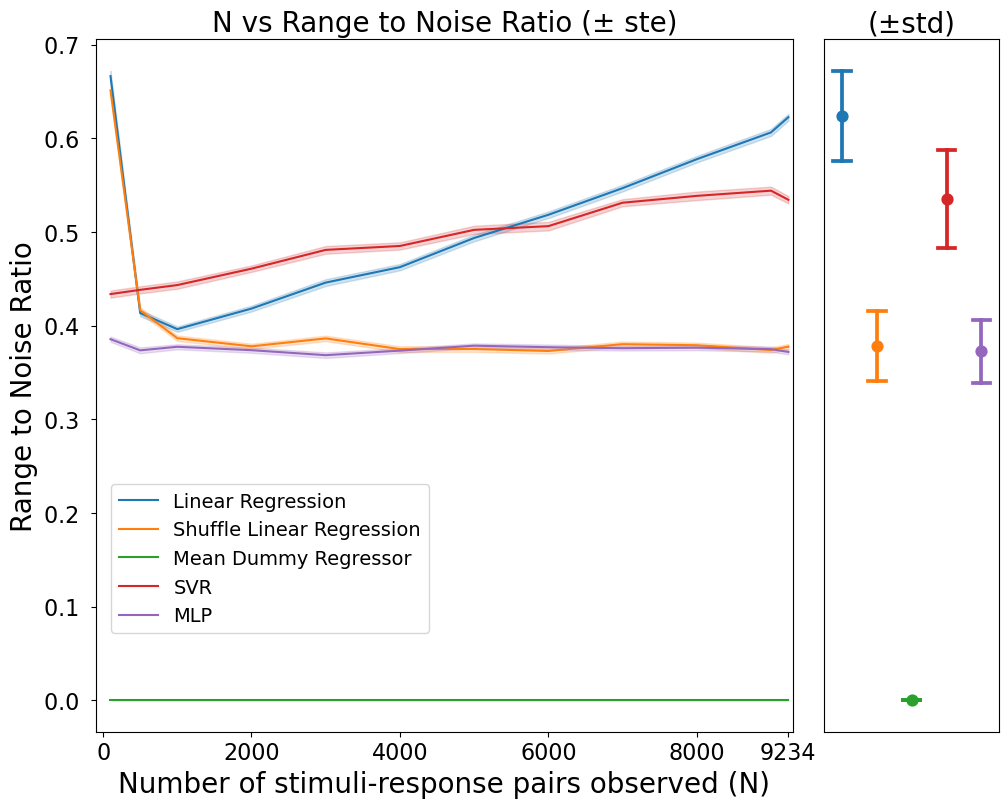

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, 
                               figsize=(10, 8), 
                               gridspec_kw={'width_ratios': [4, 1]})

metric_name = 'signal_to_uncertainty_ratio' # this is np.std(np.mean(scores, axis=1)) / np.mean(np.std(scores, axis=1))

sns.lineplot(data=df, 
             x='training_size', 
             y=metric_name, 
             hue='method_name', 
             errorbar=('se', 1),
             ax=ax1)


# Clear the existing legend
ax1.get_legend().remove()
# Create a new legend with custom labels and position
handles, labels = ax1.get_legend_handles_labels()
print(labels)
# new_labels = ['Linear Regression', 'Shuffle Linear Regression', 'Dummy Regressor (Mean)', 'Theoretical Random Retrieval']  # Replace with your desired labels
new_labels = ['Linear Regression', 'Shuffle Linear Regression', 'Mean Dummy Regressor', 'SVR', 'MLP']  # Replace with your desired labels
print(new_labels)
ax1.legend(handles, new_labels, 
           bbox_to_anchor=(0.25, 0.25),  # x, y coordinates inside the plot
           loc='center',               # Center the legend box at the specified coordinates
           # title_fontsize=14,
           fontsize=plotconfig.LEGEND_FONTSIZE)

ax1.set_title("N vs Range to Noise Ratio (± ste)", fontsize=plotconfig.LABEL_FONTSIZE)
ax1.set_xlabel("Number of stimuli-response pairs observed (N)", fontsize=plotconfig.LABEL_FONTSIZE)
ax1.set_ylabel("Range to Noise Ratio", fontsize=plotconfig.LABEL_FONTSIZE)

current_xticks = ax1.get_xticks()
new_xticks = np.sort(np.append(current_xticks, np.max(df['training_size'])
))
ax1.set_xticks(new_xticks)


def custom_formatter(x, pos):
    if np.isclose(x, -0.773, rtol=1e-03, atol=1e-03):
        return f"{x:.2f}"
    else:
        return f"{x:.1f} "

ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax1.yaxis.set_major_formatter(FuncFormatter(custom_formatter))

ax1.tick_params(axis='x', labelsize=plotconfig.TICK_SIZE)
ax1.tick_params(axis='y', labelsize=plotconfig.TICK_SIZE)

# ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
# plt.gca().yaxis.set_major_formatter(FuncFormatter(custom_formatter))
# plt.gca().xaxis.set_major_locator(plt.AutoLocator())
# ylim = [-0.1, 3]
ax1.set_xlim(-100, 9300)  # Set x-axis limits from 0 to 60
# ax1.set_ylim(ylim)  # Set y-axis limits from 0 to 10
# ax1.invert_yaxis()

df_last = df[df['training_size'] == plotconfig.LAST_N]

sns.pointplot(x='method_name', y=metric_name, hue='method_name', data=df_last, 
              capsize=0.5, linestyle='none', errorbar='sd')

ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('(±std)', fontsize=plotconfig.LABEL_FONTSIZE)
ax2.tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Remove y-ticks and labels
ax2.tick_params(axis='y', which='both', left=False, labelleft=False)  # Remove y-ticks and labels

# ax2.set_ylim(ylim)  # Set y-axis limits from 0 to 10
# ax2.invert_yaxis()

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

plotconfig.save_fig('signal_variation_to_uncertainty_ratio')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


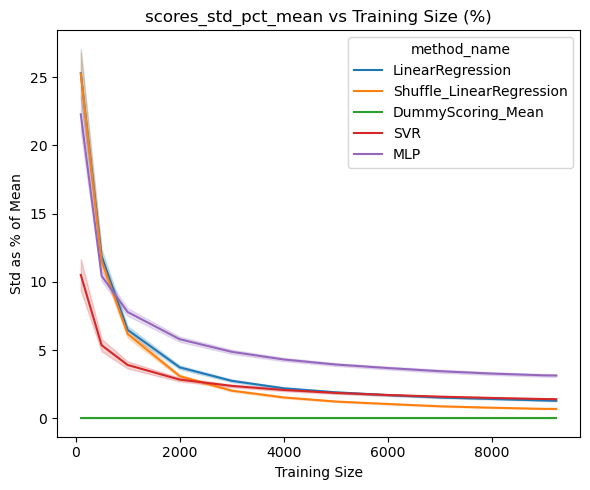

In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Calculate means for all metrics ---
df['scores_std_mean'] = df['scores_std'].apply(lambda x: np.mean(x))
df['raw_scores_std_mean'] = df['raw_scores_std'].apply(lambda x: np.mean(x))
df['shuffled_scores_std_mean'] = df['shuffled_scores_std'].apply(lambda x: np.mean(x))

df['scores_mean'] = df['scores'].apply(lambda x: np.mean(x))
df['raw_scores_mean'] = df['raw_scores'].apply(lambda x: np.mean(x))
df['shuffled_scores_mean'] = df['shuffled_scores'].apply(lambda x: np.mean(x))

# --- Calculate std as percentage ---
df['scores_std_pct'] = df.apply(lambda row: [(std/score)*100 for std, score in zip(row['scores_std'], row['scores'])], axis=1)
df['raw_scores_std_pct'] = df.apply(lambda row: [(std/score)*100 for std, score in zip(row['raw_scores_std'], row['raw_scores'])], axis=1)
df['shuffled_scores_std_pct'] = df.apply(lambda row: [(std/score)*100 for std, score in zip(row['shuffled_scores_std'], row['shuffled_scores'])], axis=1)

# --- Mean of the percentage lists ---
df['scores_std_pct_mean'] = df['scores_std_pct'].apply(lambda x: np.mean(x))
df['raw_scores_std_pct_mean'] = df['raw_scores_std_pct'].apply(lambda x: np.mean(x))
df['shuffled_scores_std_pct_mean'] = df['shuffled_scores_std_pct'].apply(lambda x: np.mean(x))

# --- Select only the bottom-left plot metric ---
# bottom-left = third row, first column = 'scores_std_pct_mean'
metric_name = 'scores_std_pct_mean'

plt.figure(figsize=(6, 5))
sns.lineplot(
    data=df,
    x='training_size',
    y=metric_name,
    hue='method_name',
    errorbar=('sd', 1)
)

plt.title(f'{metric_name} vs Training Size (%)')
plt.ylabel('Std as % of Mean')
plt.xlabel('Training Size')
plt.tight_layout()

plotconfig.save_fig('signal_std_as_percent_of_mean')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


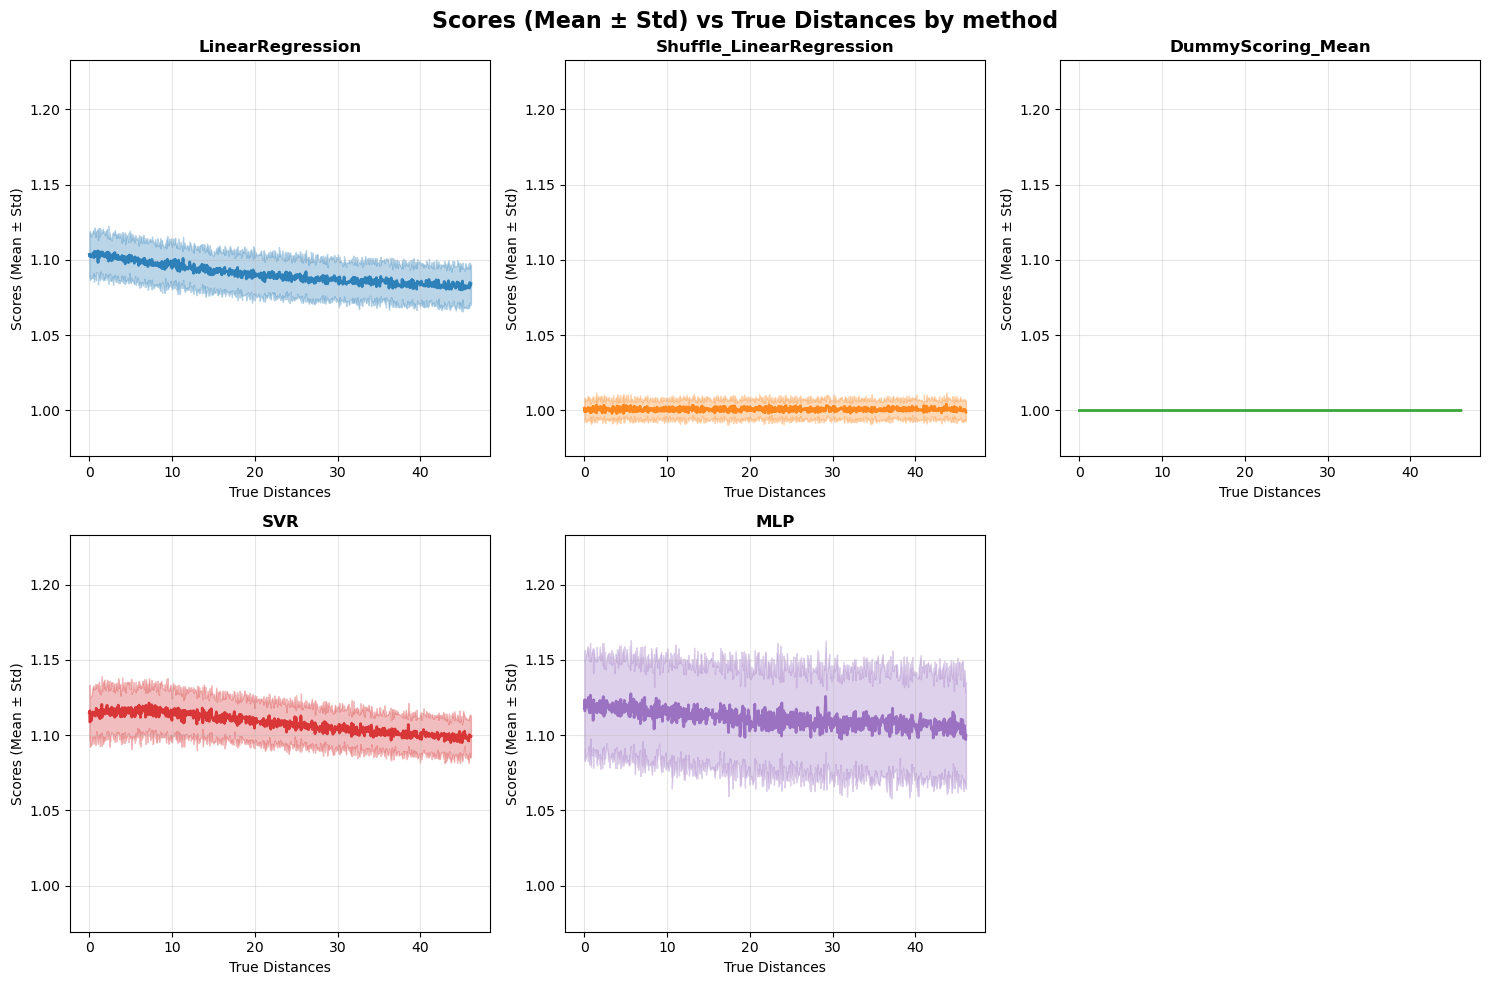

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# Your existing data loading and filtering code
dbf = os.path.join(_FINAL_DFS_DIR, 'results.parquet')
df = pd.read_parquet(dbf, engine='pyarrow')

mask = ((df['method_name'] != "BestSVR") &
        (df['method_name'] != "BestMLP") &
        (df['eeg_name'] == "EEG_Raw") & 
        (df['test_name'] == "random"))

df = df[mask]

# Filter for only training_size 9234
df_filtered = df[df['training_size'] == 9234]


# --- Get unique methods IN THE DESIRED ORDER ---
# Target order: 1) Linear Regression, 2) Shuffle Linear Regression,
#               3) Dummy Regressor, 4) SVR, 5) MLP, then anything else.

methods_raw = list(df_filtered['method_name'].unique())

def method_rank(name: str) -> int:
    n = name.lower().replace('_', ' ').replace('-', ' ')
    # 0: Linear Regression (non-shuffled)
    if 'linear' in n and not ('shuffle' in n or 'shuffled' in n):
        return 0
    # 1: Shuffle/Shuffled Linear Regression
    if 'linear' in n and ('shuffle' in n or 'shuffled' in n):
        return 1
    # 2: Dummy Regressor
    if 'dummy' in n:
        return 2
    # 3: SVR / Support Vector
    if 'svr' in n or 'support vector' in n:
        return 3
    # 4: MLP / Multilayer Perceptron
    if 'mlp' in n or 'multi layer' in n or 'multilayer' in n or 'perceptron' in n:
        return 4
    # Everything else goes after the main five
    return 100

# Sort by our custom rank, then by name for stable ordering within ties
unique_methods = sorted(methods_raw, key=lambda m: (method_rank(m), m))
n_methods = len(unique_methods)

# print("Plot order:")
# for i, m in enumerate(unique_methods, 1):
#     print(f"{i:2d}. {m}")

# Calculate subplot layout
n_cols = 3  # 3 columns
n_rows = int(np.ceil(n_methods / n_cols))

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))

# If only one row, make sure axes is a list
if n_rows == 1:
    axes = axes.reshape(1, -1)
elif n_methods == 1:
    axes = np.array([[axes]])

# Flatten axes for easier indexing
axes_flat = axes.flatten()

# Focus on scores metric
metric_name = 'scores'
metric_std_name = 'scores_std'

# Find global y-axis limits by processing all data first
all_y_values = []
all_y_errors = []

for method_name in unique_methods:
    method_data = df_filtered[df_filtered['method_name'] == method_name]
    if len(method_data) > 0:
        df_exploded = method_data.explode(['true_distances', metric_name, metric_std_name])
        df_exploded[metric_name] = pd.to_numeric(df_exploded[metric_name])
        df_exploded[metric_std_name] = pd.to_numeric(df_exploded[metric_std_name])
        
        # Include error bars in y-axis calculation
        y_vals = df_exploded[metric_name].dropna()
        y_errs = df_exploded[metric_std_name].dropna()
        
        all_y_values.extend((y_vals - y_errs).tolist())  # Lower bounds
        all_y_values.extend((y_vals + y_errs).tolist())  # Upper bounds

# Calculate global y-axis limits
if all_y_values:
    y_min = min(all_y_values)
    y_max = max(all_y_values)
    # Add some padding
    y_range = y_max - y_min
    y_min_padded = y_min - 0.05 * y_range
    y_max_padded = y_max + 0.05 * y_range
else:
    y_min_padded, y_max_padded = 0, 1


# --- Create a consistent color palette across all methods ---
# Use the same palette Seaborn would assign automatically in your second plot
palette = sns.color_palette(n_colors=len(unique_methods))

# Map each method to its corresponding color in the palette
method_colors = {method: color for method, color in zip(unique_methods, palette)}

# print("Assigned colors:")
# for method, color in method_colors.items():
#     print(f"{method}: {color}")

for i, method_name in enumerate(unique_methods):
    # Filter data for this method
    method_data = df_filtered[df_filtered['method_name'] == method_name]
    
    if len(method_data) > 0:
        # Create exploded data including std
        df_exploded = method_data.explode(['true_distances', metric_name, metric_std_name])
        
        # Convert to numeric
        df_exploded['true_distances'] = pd.to_numeric(df_exploded['true_distances'])
        df_exploded[metric_name] = pd.to_numeric(df_exploded[metric_name])
        df_exploded[metric_std_name] = pd.to_numeric(df_exploded[metric_std_name])
        
        # Group by true_distances to get mean and std for plotting
        # (in case there are multiple rows for the same method-training size combination)
        plot_data = df_exploded.groupby('true_distances').agg({
            metric_name: 'mean',
            metric_std_name: 'mean'  # Average the std if multiple rows
        }).reset_index()
        
        # Create the line plot with shaded area for std using the pre-calculated std
        axes_flat[i].plot(
            plot_data['true_distances'], 
            plot_data[metric_name],
            linewidth=2,
            alpha=0.9,
            color=method_colors[method_name]
        )

        # Add shaded area for standard deviation
        axes_flat[i].fill_between(
            plot_data['true_distances'],
            plot_data[metric_name] - plot_data[metric_std_name],
            plot_data[metric_name] + plot_data[metric_std_name],
            alpha=0.3,
            color=method_colors[method_name]
        )

        # Set title and labels
        axes_flat[i].set_title(f'{method_name}', fontsize=12, fontweight='bold')
        axes_flat[i].set_xlabel('True Distances', fontsize=10)
        axes_flat[i].set_ylabel('Scores (Mean ± Std)', fontsize=10)
        
        # Set the same y-axis limits for all subplots
        axes_flat[i].set_ylim(y_min_padded, y_max_padded)
        
        # Add grid for better readability
        axes_flat[i].grid(True, alpha=0.3)
        
    else:
        # If no data for this method, hide the subplot
        axes_flat[i].set_visible(False)

# Hide any unused subplots
for j in range(i + 1, len(axes_flat)):
    axes_flat[j].set_visible(False)

# Set overall title
fig.suptitle(f'Scores (Mean ± Std) vs True Distances by method', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.subplots_adjust(top=0.93)  # Make room for the main title

plotconfig.save_fig('signal_mean_std_vs_true_distances')

# print(f"Created subplots for {len(unique_methods)} methods:")
# for method in unique_methods:
#     n_runs = len(df_filtered[df_filtered['method_name'] == method])
#     print(f"  - {method}: {n_runs} run(s)")
# print(f"Y-axis range: {y_min_padded:.3f} to {y_max_padded:.3f}")

# print("\nNote: Error bars represent the pre-calculated standard deviations from the original data,")
# print("not standard deviations calculated from exploded points.")